In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor


In [2]:
# download the dataset
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-11-08 06:55:12--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  2.09MB/s    in 0.4s    

2025-11-08 06:55:13 (2.09 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [3]:
fuel_df = pd.read_csv('car_fuel_efficiency.csv')
fuel_df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
# missing columns
fuel_df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [5]:
fuel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


In [14]:
fuel_df.describe()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,num_doors,fuel_efficiency_mpg
count,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000
mean,199.708368,3.765664,138.738355,3001.280993,13.582275,2011.484027,-0.006080,14.985243
std,49.455319,2.130715,48.401189,497.894860,5.025294,6.659808,1.020689,2.556468
min,10.000000,0.000000,0.000000,952.681761,0.000000,2000.000000,-4.000000,6.200971
25%,170.000000,2.000000,124.000000,2666.248985,12.600000,2006.000000,-1.000000,13.267459
50%,200.000000,4.000000,146.000000,2993.226296,14.700000,2012.000000,0.000000,15.006037
75%,230.000000,5.000000,168.000000,3334.957039,16.500000,2017.000000,1.000000,16.707965
max,380.000000,13.000000,271.000000,4739.077089,24.300000,2023.000000,4.000000,25.967222


In [6]:
# fill missing values with 0
fuel_df = fuel_df.fillna(0)

In [7]:
fuel_df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [8]:
# train test split
fuel_full_train, fuel_test = train_test_split(fuel_df, test_size=0.2, random_state=1)
fuel_train, fuel_val = train_test_split(fuel_full_train, test_size=0.25, random_state=1)

# get y values
y_train = fuel_train.fuel_efficiency_mpg.values
y_val = fuel_val.fuel_efficiency_mpg.values
y_test = fuel_test.fuel_efficiency_mpg.values

# drop target column
fuel_train = fuel_train.drop('fuel_efficiency_mpg', axis=1)
fuel_val = fuel_val.drop('fuel_efficiency_mpg', axis=1)
fuel_test = fuel_test.drop('fuel_efficiency_mpg', axis=1)

# create dict vectorizer
dv = DictVectorizer(sparse=False)
train_dicts = fuel_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = fuel_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

X_test = dv.transform(fuel_test.to_dict(orient='records'))

# check shapes
X_train.shape, X_val.shape, X_test.shape, fuel_full_train.shape

((5822, 14), (1941, 14), (1941, 14), (7763, 11))

In [10]:
features_names = list(dv.get_feature_names_out())
features_names

['acceleration',
 'drivetrain=All-wheel drive',
 'drivetrain=Front-wheel drive',
 'engine_displacement',
 'fuel_type=Diesel',
 'fuel_type=Gasoline',
 'horsepower',
 'model_year',
 'num_cylinders',
 'num_doors',
 'origin=Asia',
 'origin=Europe',
 'origin=USA',
 'vehicle_weight']

### **Question 1: Train a decision tree regressor with max_depth=1**

Determine which feature was used for splitting 

In [21]:
dtr = DecisionTreeRegressor(max_depth=1, random_state=1)
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {round(rmse, 3)}")

RMSE: 1.61


In [18]:
r2_value = r2_score(y_val, y_pred)
print(f"R2 Score: {round(r2_value, 3)}")

R2 Score: 0.614


In [15]:
from sklearn.tree import export_text
r = export_text(dtr, feature_names=features_names)
print(r)

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



### **Question 2: Train a random forest regressor with these parameters:**
    - n_estimators=10
    - random_state=1
    - n_jobs=-1

In [26]:
rfr = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            n_jobs=-1)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2_value = r2_score(y_val, y_pred)
print(f"R2 Score: {round(r2_value, 3)}")
print(f"RMSE: {round(rmse, 3)}")


R2 Score: 0.969
RMSE: 0.46


## **Hyperparameter Tuning**

### **Question 3:**
- Experiment with n_estimators parameter. Try different values from 10 - 200 with step of 10. 

- Set random_state to 1
- Evaluate model on the validation dataset

In [28]:
scores = []

for n in range(10, 201, 10):
    rfr = RandomForestRegressor(n_estimators=n,
                               random_state=1,
                               n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, rmse))

scores_df = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
print(scores_df.sort_values(by='rmse', ascending=False))

    n_estimators      rmse
0             10  0.459978
1             20  0.453659
2             30  0.450743
3             40  0.448007
4             50  0.446151
5             60  0.445266
7             80  0.444893
8             90  0.444724
6             70  0.444610
9            100  0.444318
11           120  0.443529
12           130  0.443364
13           140  0.443180
10           110  0.443135
14           150  0.442910
16           170  0.442716
15           160  0.442629
19           200  0.442607
18           190  0.442579
17           180  0.442362


<Axes: xlabel='n_estimators'>

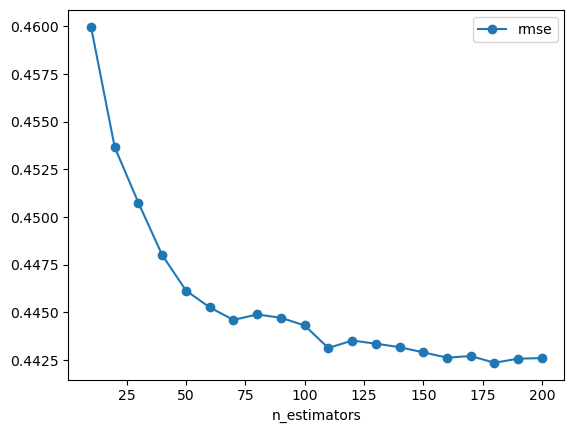

In [29]:
scores_df.plot(x='n_estimators', y='rmse', kind='line', marker='o')

### **Question 4:**
- Select the best `max_depth`. Try different values of [10, 15, 20, 25]
- For each of these values, try different values of `n_estimators` from 10 till 200 (with step of 10)
- calculate the mean RMSE
- Fix random seed: `random_state=1`

In [30]:
scores = []

for m in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=n,
                                   max_depth=m,
                                   random_state=1,
                                   n_jobs=-1)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((m, n, rmse))

scores_df = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])


    max_depth  n_estimators      rmse
60         25            10  0.459621
40         20            10  0.459109
20         15            10  0.457160
61         25            20  0.453949
41         20            20  0.453368
..        ...           ...       ...
14         10           150  0.440128
15         10           160  0.439997
18         10           190  0.439982
19         10           200  0.439942
17         10           180  0.439837

[80 rows x 3 columns]


In [31]:
scores_df.sort_values(by='rmse', ascending=False) # better max_depth=10, n_estimators=180-200

,max_depth,n_estimators,rmse
60,25,10,0.459621
40,20,10,0.459109
20,15,10,0.457160
61,25,20,0.453949
41,20,20,0.453368
...,...,...,...
14,10,150,0.440128
15,10,160,0.439997
18,10,190,0.439982
19,10,200,0.439942


### **Question 5:**
- Find the most important feature by using the `feature_importances_` method in scikit-learn
- Train a model with these parameters:
    - n_estimators=10
    - max_depth=20
    - random_state=1
    - n_jobs=-1
- Get the feature importance information from this model

In [35]:
rffi = RandomForestRegressor(n_estimators=10,
                             max_depth=20,
                             random_state=1,
                             n_jobs=-1)

rffi.fit(X_train, y_train)
feature_importances = zip(rffi.feature_importances_, features_names)
df = pd.DataFrame(feature_importances, columns=['importance', 'feature'])

In [37]:
df.sort_values(by='importance', ascending=False)

,importance,feature
13,0.959162,vehicle_weight
6,0.016040,horsepower
0,0.011471,acceleration
3,0.003269,engine_displacement
7,0.003182,model_year
8,0.002359,num_cylinders
9,0.001591,num_doors
12,0.000555,origin=USA
11,0.000520,origin=Europe
10,0.000476,origin=Asia


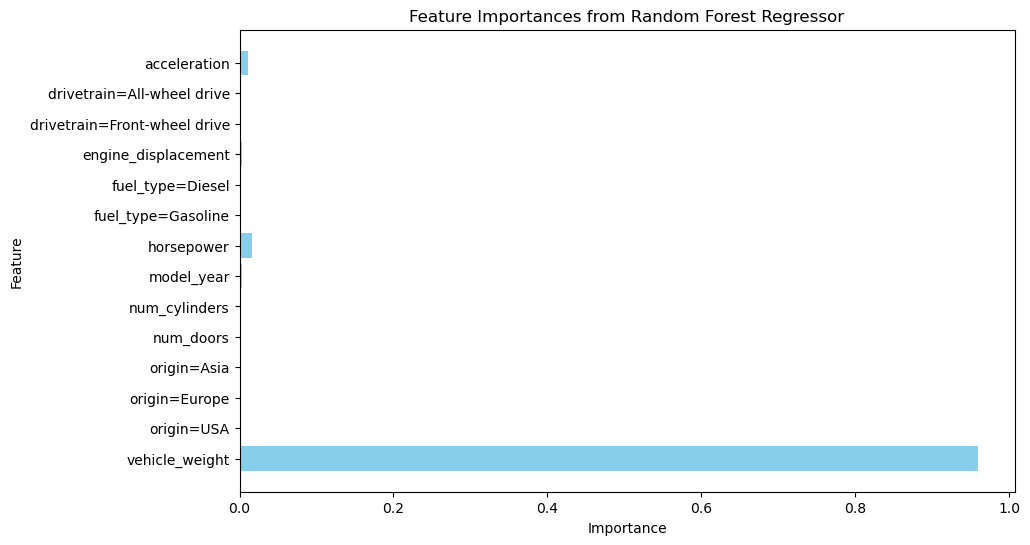

In [39]:
# plot feature importance
plt.figure(figsize=(10,6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.title('Feature Importances from Random Forest Regressor')
plt.show()

### **Question 6:**
- Train an XGBoost model with `eta` tuning
- Your params are:
    - xgb_params = {
        'eta': 0.3,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1
        }
- Create DMatrix for train and validation
- Create a watchlist
- Train model with the above parameters for `100` rounds
- Change `eta` to 0.1 after training at 0.3. Which `eta` leads to the best RMSE score on the validation dataset

In [41]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train,
                     label=y_train,
                     feature_names=features_names)

dval = xgb.DMatrix(X_val, 
                   label=y_val,
                   feature_names=features_names)

In [44]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

watchlist = [(dtrain, 'train'), (dval, 'val')]
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=watchlist,
    evals_result=evals_result,
    verbose_eval=10
)

[0]	train-rmse:1.81393	val-rmse:1.85444
[10]	train-rmse:0.37115	val-rmse:0.43896
[20]	train-rmse:0.33553	val-rmse:0.43376
[30]	train-rmse:0.31475	val-rmse:0.43752
[40]	train-rmse:0.30202	val-rmse:0.43968
[50]	train-rmse:0.28456	val-rmse:0.44140
[60]	train-rmse:0.26768	val-rmse:0.44290
[70]	train-rmse:0.25489	val-rmse:0.44531
[80]	train-rmse:0.24254	val-rmse:0.44689
[90]	train-rmse:0.23193	val-rmse:0.44839
[99]	train-rmse:0.21950	val-rmse:0.45018


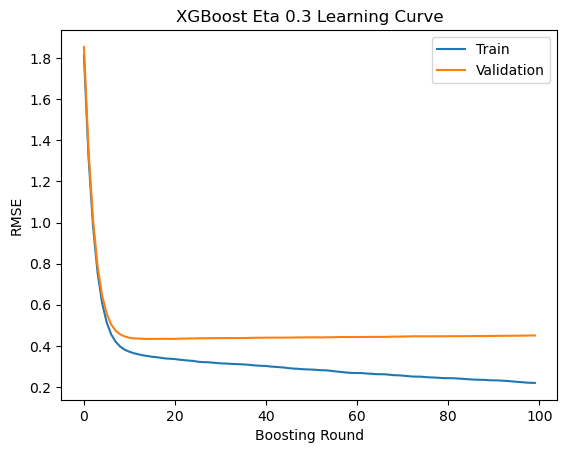

In [45]:
# Plot the learning curve
plt.plot(evals_result['train']['rmse'], label='Train')
plt.plot(evals_result['val']['rmse'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Eta 0.3 Learning Curve')
plt.legend()
plt.show()

In [46]:
# eta 0.1
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

watchlist = [(dtrain, 'train'), (dval, 'val')]
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=watchlist,
    evals_result=evals_result,
    verbose_eval=10
)

[0]	train-rmse:2.28944	val-rmse:2.34561
[10]	train-rmse:0.91008	val-rmse:0.94062


[20]	train-rmse:0.48983	val-rmse:0.53064
[30]	train-rmse:0.38342	val-rmse:0.44289
[40]	train-rmse:0.35343	val-rmse:0.42746
[50]	train-rmse:0.33998	val-rmse:0.42498
[60]	train-rmse:0.33054	val-rmse:0.42456
[70]	train-rmse:0.32202	val-rmse:0.42503
[80]	train-rmse:0.31667	val-rmse:0.42563
[90]	train-rmse:0.31059	val-rmse:0.42586
[99]	train-rmse:0.30419	val-rmse:0.42623


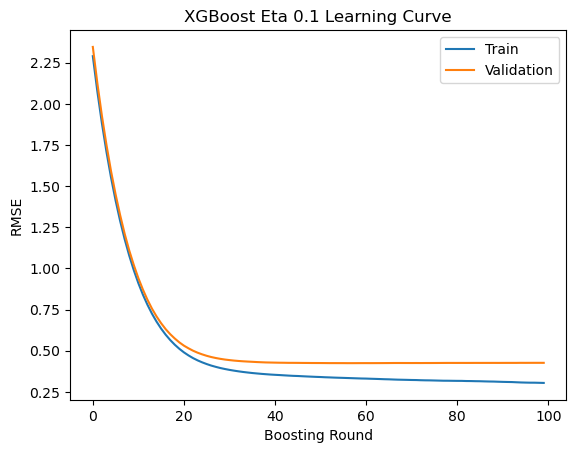

In [47]:
# Plot the learning curve
plt.plot(evals_result['train']['rmse'], label='Train')
plt.plot(evals_result['val']['rmse'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Eta 0.1 Learning Curve')
plt.legend()
plt.show()